# Wellflow Trial

import wellflow

In [1]:
import wellflow as wf

`read_plate_measurements` reads in the raw measurements from the plate reader.

Required inputs:

`path`: Full path to the plate reader measurement file.

`header_row`: The row in the Excel sheet where the header appears (e.g., Time, wells, etc.). Defaults to 1, but for our plate reader the header is typically around row 44.

`last_row`: Usually unnecessary if you isolated the measurements into a separate spreadsheet. However, when reading directly from the plate reader output, additional non-measurement rows may appear below the data, so you should specify the last row to read.

`start_col`: The column where the data begins. For example, in our case the data starts in column B.

`data_format`: The format of the data. Our plate reader outputs data in "wide" format.

`timepoint_col`: A list of all columns that contain per-timepoint information shared across the entire plate (including the Time column itself), such as temperature or CO₂ level.

`reader_model`: The plate reader model used. Our model is Synergy H1.

In [2]:
raw = wf.read_plate_measurements(path='example_widedata.xlsx',
                                header_row=44,
                                last_row=237,
                                start_col='B',
                                data_format='wide',
                                timepoint_cols=["Time", "T° 600"],
                                reader_model ="Synergy H1")

`read_plate_layout`


To load the plate layout, you need to provide:

`path`: Path to the plate layout file.

`format`: Layout format. Currently, only "column_blocks" is supported, but additional formats will be added in future versions.

In [3]:
layout = wf.read_plate_layout(path='example_layout.xlsx',
                             format='column_blocks')

`merge_measurements_and_conditions`

To merge the measurements with the plate layout, you need to provide:

`measurements`: The DataFrame loaded using read_plate_measurements.
`conditions`: The plate layout loaded using read_plate_layout.

In [4]:
full = wf.merge_measurements_and_conditions(measurements= raw,
                                            conditions=layout)

`drop_flags`

You may decide that some wells should be removed from the analysis.

This can be done by documenting the wells and the reason for their removal in an Excel sheet, then using this function.

You need to provide:

`measurements`: The DataFrame loaded using read_plate_measurements, with or without merged conditions.

`flags`: Either a path to the Excel file containing flagged wells, or a DataFrame already loaded using read_flagged_wells.

In [5]:
wo_flags = wf.drop_flags(measurements=full,
                        flags = "flags.xlsx")

`add_flag_column`

You may want to keep flagged wells in your calculations while marking them so they can be filtered out later (for example, during plotting).

You need to provide:

`measurements`: The measurements DataFrame, with or without merged conditions.
`flagged_wells`: Path to the Excel file containing the flagged wells.

In [6]:
with_flags_col = wf.add_flag_column(measurements=full,
                                      flagged_wells="flags.xlsx")

`with_blank_corrected_od`

Blank correction removes baseline signal (for example, media or background absorbance). For each well, we average the first N timepoints and subtract that value from all measurements so early noise does not dominate the signal.

We never modify the raw data. Instead, we only add new columns that contain additional information.

To add a column with blank-corrected OD, you need to provide:

`df`: The measurements DataFrame.

`window`: The number of initial data points to average and subtract from all measurements.

`od_col`: Defaults to "od", which corresponds to the raw OD values. This can be changed to any other OD column (for example, if you want to apply smoothing first).

In [7]:
blanked = wf.with_blank_corrected_od(df=with_flags_col,
                                     window = 4)

`with_smoothed_od`

To add a smoothed OD column, you need to provide:

`df`: The measurements DataFrame.
`group_by`: Defaults to "well". You may want to change this when performing per-group calculations, such as when grouping by condition. In that case, set group_by to a list of condition columns, for example ["strain"] or ["strain", "formate_conc", "formate_source"].

`od_col`: Name of the OD column to smooth. Defaults to "od_blank", but you can change this if you want to smooth before blanking, or if you want to smooth an aggregated OD (for example, after grouping by condition and computing a mean_od column).

`window`: Smoothing replaces each value with the average of the surrounding values. window specifies the size of that surrounding window.

In [8]:
smoothed = wf.with_smoothed_od(df=blanked, 
           window = 5)

`add_growth_rate`

Growth rate is computed at each individual time point by performing a linear regression on log(OD) within a local window and taking the slope of that regression.

To calculate growth rate, you need to provide:

`df`: The measurements DataFrame.

`window`: Number of points around each time point to include in the linear regression.

`epsilon`: When OD = 0, log(OD) is undefined, and when OD ≈ 0, log(OD) becomes a very large negative number. We avoid these cases, especially since very low OD values are unlikely to represent meaningful biological measurements. For points with OD < epsilon, growth rate is not calculated and defaults to NaN. epsilon defaults to e⁻¹⁰, but you can change it to any value you consider biologically insignificant.

`group_by`: Same as before. Defaults to "well" because growth rate is typically calculated per well. If you are grouping measurements, provide a list of columns that define each group.

`od_col`: Name of the OD column used for the calculation. Defaults to "od_smooth", but can be changed, for example when working with grouped or aggregated OD values.

In [9]:
with_mu = wf.add_growth_rate(df= smoothed,
                             window = 9,
                             od_col="od_smooth")

`estimate_early_od_threshold`

This function examines the selected OD column across the first n time points from all wells. It computes the q-th quantile (for example, the 95th percentile) of those early OD values and returns that value as the early OD threshold.

Early measurements are often close to baseline (blank or no growth) and can be noisy. By taking a high quantile of early OD readings, you obtain a conservative cutoff that separates likely noise or baseline signal from meaningful growth.

Downstream analyses (such as identifying the maximum growth rate) can use this threshold to ignore windows where OD values are too low to be informative. This helps avoid log(0) issues and spurious growth-rate estimates.

You need to provide:

`df`: The measurements DataFrame.

`od_col`: Important: This column should always be post-blanking. If you compute the threshold before blanking and then apply blank correction afterward, the threshold will be artificially inflated because all values shift.

`n_points`: Number of early time points to include across the entire plate.

`q`: Quantile to compute (that is, the percentage cutoff you want).

In [10]:
threshold = wf.estimate_early_od_threshold(df=with_mu, 
                                          od_col="od",
                                          n_points = 5,
                                          q = 0.95)

`summarize_mu_max`

This function creates a separate DataFrame containing the maximum growth rate for each group (per well or per any set of conditions). The output includes:

`mu_max`: The fastest growth rate observed.

`mu_low`: The lower bound of the 95% confidence interval.

`mu_high`: The upper bound of the 95% confidence interval.

`tau`: Doubling time based on mu_max.

`tau_2p5`: Doubling time based on mu_high (fastest case).

`tau_97p5`: Doubling time based on mu_low (slowest case).

You need to provide:

`df`: The measurements DataFrame.

`group_by`: Defaults to "well", but can be changed when summarizing by condition or other groupings.

`window`: mu_max is calculated by performing linear regression within sliding windows and selecting the window with the maximum slope. window specifies the size of that window.

`od_col`: Name of the OD column to use. Defaults to "od_smooth", but can be changed, for example when working with grouped or aggregated OD values.

`threshold`: Only windows where all points are above a specified OD threshold are considered valid candidates for maximum growth rate. If threshold is not provided, it is computed using estimate_early_od_threshold. You may also set it manually to any value ≥ e⁻¹⁰.

In [11]:
mu_max_summary = wf.summarize_mu_max(df = with_mu,
                                     window = 5)

No meaningful growth found for this group: B11
No meaningful growth found for this group: C11
No meaningful growth found for this group: D11


## Grouping

So far, we have worked at the level of individual wells. Here is how we handle grouping by condition.

To make this easier, you can specify once which conditions you want to group by and reuse that definition throughout the analysis.

In this case, we want to group by both strain and biological replicate.

In [12]:
group =["strain", "bio rep", "time_hours"]

We want to take the smoothed OD (per well) and aggregate that into a mean OD per condition

In [13]:
by_cond = (with_mu.groupby(group, as_index=False)
    .agg(
        od_mean=("od", "mean"),
        od_std=("od_smooth", "std"),
        mu_mean=("mu", "mean"),
        mu_std=("mu", "std"),
        n=("od_smooth", "size"),
        
    )
)

If we want to exclude the growth rate of points where we think the OD is not 
reliable (i.e., below the estimated threshold), we can filter those out before aggregating:

First calculate the threshold,

mask is a boolean list 

by_cond_filtered takes the filtered DataFrame and groups it just like we did before 

In [16]:
threshold = wf.estimate_early_od_threshold(df=with_mu, 
                                          od_col="od",
                                          n_points = 5,
                                          q = 0.95)
mask = with_mu['od'] >= threshold
filtered = with_mu[mask]

by_cond_filtered = (filtered.groupby(group, as_index=False)
    .agg(
        od_mean=("od", "mean"),
        od_std=("od", "std"),
        mu_mean=("mu", "mean"),
        mu_std=("mu", "std"),
        n=("od_smooth", "size"),
        
    )
)

plotting the filtered data, we lost the initial "jump"

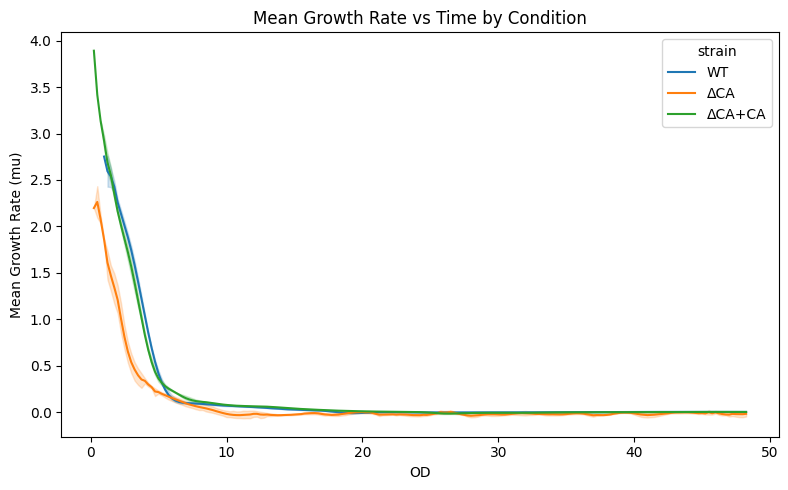

In [17]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=by_cond_filtered, x="time_hours", y="mu_mean", hue="strain")
plt.xlabel("OD")
plt.ylabel("Mean Growth Rate (mu)")
plt.title("Mean Growth Rate vs Time by Condition")
plt.tight_layout()